# Intro
In this notebook we'll develop a Random Forest for predictive maintenance on FD003 to predict the Remaining Useful Life (RUL) of the engines. FD003 is characterized by the engines developing one of two possible fault modes (see metadata below). 

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Operating conditions: ONE
Fault Modes: TWO (HPC Degradation, Fan Degradation)

In [98]:
import seaborn as sns
import os
import pandas as pd
import numpy as np
np.random.seed(1337)
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)


import missingno as msno

Pandas version:  2.0.3
Numpy version:  1.24.3


In [2]:
#%pip install missingno

In [3]:
# settings will be used to avoid exponential values in output or tables and to display 50 rows maximum

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

In [4]:
# define filepath and files to read data

train_file = 'train_FD003.txt'
test_file = 'test_FD003.txt'

# define column names for easy indexing
index_names = ['unit', 'time']
setting_names = ['op1', 'op2', 'op3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((train_file), sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv((test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv(('RUL_FD003.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

In [5]:
print(train.shape)
train.head()

(24720, 26)


,unit,time,op1,op2,op3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.001,0.000,100.000,518.670,642.360,1583.230,1396.840,14.620,...,522.310,2388.010,8145.320,8.425,0.030,391,2388,100.000,39.110,23.354
1,1,2,0.001,-0.000,100.000,518.670,642.500,1584.690,1396.890,14.620,...,522.420,2388.030,8152.850,8.440,0.030,392,2388,100.000,38.990,23.449
2,1,3,-0.001,-0.000,100.000,518.670,642.180,1582.350,1405.610,14.620,...,522.030,2388.000,8150.170,8.390,0.030,391,2388,100.000,38.850,23.367
3,1,4,-0.002,0.000,100.000,518.670,642.920,1585.610,1392.270,14.620,...,522.490,2388.080,8146.560,8.388,0.030,392,2388,100.000,38.960,23.295
4,1,5,0.002,0.000,100.000,518.670,641.680,1588.630,1397.650,14.620,...,522.580,2388.030,8147.800,8.387,0.030,392,2388,100.000,39.140,23.458


## Calculating RUL

For each time entry, there is a corresponding variable that identifies how many days are left (Remaining Useful Life)

In [6]:
# before we start plotting, let's add RUL
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit")
    max_cycle = grouped_by_unit["time"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [7]:
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit,time,RUL
0,1,1,258
1,1,2,257
2,1,3,256
3,1,4,255
4,1,5,254


In [8]:
train

,unit,time,op1,op2,op3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.001,0.000,100.000,518.670,642.360,1583.230,1396.840,14.620,...,2388.010,8145.320,8.425,0.030,391,2388,100.000,39.110,23.354,258
1,1,2,0.001,-0.000,100.000,518.670,642.500,1584.690,1396.890,14.620,...,2388.030,8152.850,8.440,0.030,392,2388,100.000,38.990,23.449,257
2,1,3,-0.001,-0.000,100.000,518.670,642.180,1582.350,1405.610,14.620,...,2388.000,8150.170,8.390,0.030,391,2388,100.000,38.850,23.367,256
3,1,4,-0.002,0.000,100.000,518.670,642.920,1585.610,1392.270,14.620,...,2388.080,8146.560,8.388,0.030,392,2388,100.000,38.960,23.295,255
4,1,5,0.002,0.000,100.000,518.670,641.680,1588.630,1397.650,14.620,...,2388.030,8147.800,8.387,0.030,392,2388,100.000,39.140,23.458,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.002,-0.000,100.000,518.670,643.780,1596.010,1424.110,14.620,...,2388.300,8138.080,8.504,0.030,394,2388,100.000,38.440,22.963,4
24716,100,149,0.003,-0.000,100.000,518.670,643.290,1596.380,1429.140,14.620,...,2388.280,8144.360,8.517,0.030,395,2388,100.000,38.500,22.975,3
24717,100,150,-0.002,0.000,100.000,518.670,643.840,1604.530,1431.410,14.620,...,2388.240,8135.950,8.522,0.030,396,2388,100.000,38.390,23.068,2
24718,100,151,-0.002,0.000,100.000,518.670,643.940,1597.560,1426.570,14.620,...,2388.260,8141.240,8.515,0.030,395,2388,100.000,38.310,23.075,1


In [9]:
# prep data
# drop unwanted columns and split target variable from training set
#drop_sensors = ['s_1','s_5','s_16','s_18','s_19']  # s_6 and s_10 get the benefit of the doubt
drop_labels = index_names+setting_names
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']


X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125)  # apply RUL clipping from earlier posts

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit').last().reset_index().drop(drop_labels, axis=1)
df_max_rul = train[['unit', 'RUL']].groupby('unit').first().reset_index()

## Consider the distribution of RUL
We can see clearly that is it right skewed. 

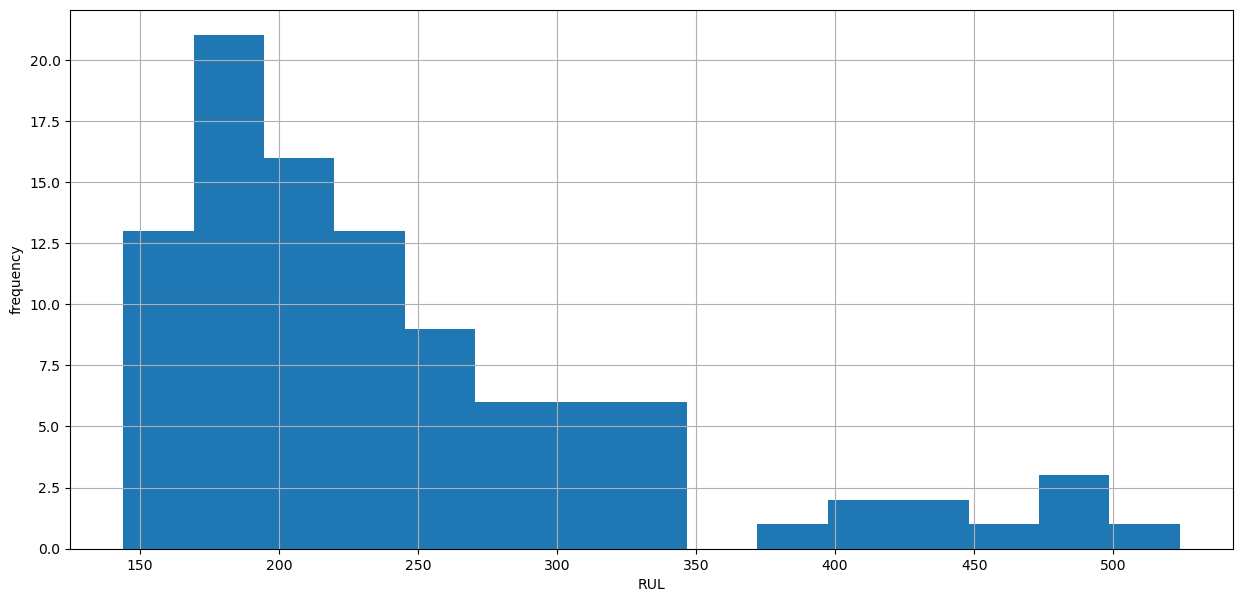

In [10]:
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel("RUL")
plt.ylabel("frequency")
plt.show()

In [11]:
train

,unit,time,op1,op2,op3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.001,0.000,100.000,518.670,642.360,1583.230,1396.840,14.620,...,2388.010,8145.320,8.425,0.030,391,2388,100.000,39.110,23.354,258
1,1,2,0.001,-0.000,100.000,518.670,642.500,1584.690,1396.890,14.620,...,2388.030,8152.850,8.440,0.030,392,2388,100.000,38.990,23.449,257
2,1,3,-0.001,-0.000,100.000,518.670,642.180,1582.350,1405.610,14.620,...,2388.000,8150.170,8.390,0.030,391,2388,100.000,38.850,23.367,256
3,1,4,-0.002,0.000,100.000,518.670,642.920,1585.610,1392.270,14.620,...,2388.080,8146.560,8.388,0.030,392,2388,100.000,38.960,23.295,255
4,1,5,0.002,0.000,100.000,518.670,641.680,1588.630,1397.650,14.620,...,2388.030,8147.800,8.387,0.030,392,2388,100.000,39.140,23.458,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.002,-0.000,100.000,518.670,643.780,1596.010,1424.110,14.620,...,2388.300,8138.080,8.504,0.030,394,2388,100.000,38.440,22.963,4
24716,100,149,0.003,-0.000,100.000,518.670,643.290,1596.380,1429.140,14.620,...,2388.280,8144.360,8.517,0.030,395,2388,100.000,38.500,22.975,3
24717,100,150,-0.002,0.000,100.000,518.670,643.840,1604.530,1431.410,14.620,...,2388.240,8135.950,8.522,0.030,396,2388,100.000,38.390,23.068,2
24718,100,151,-0.002,0.000,100.000,518.670,643.940,1597.560,1426.570,14.620,...,2388.260,8141.240,8.515,0.030,395,2388,100.000,38.310,23.075,1


# Perform Modeling

In [12]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
X_test = test.groupby('unit').last().reset_index().drop(drop_labels, axis=1)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

In [14]:
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:19.330134905061065, R2:0.7736110804777361
test set RMSE:22.319344484400546, R2:0.7092939799791147


### Linear Regression did not perform badly, but lets see if we can get a higher accuracy score.

In [15]:
X_test

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,518.670,642.590,1592.400,1409.870,14.620,21.580,560.530,2388.220,9085.500,1.310,...,528.050,2388.230,8158.770,8.297,0.030,393,2388,100.000,39.430,23.568
1,518.670,642.560,1587.420,1409.690,14.620,21.610,553.330,2388.180,9050.970,1.300,...,520.900,2388.170,8128.040,8.451,0.030,392,2388,100.000,38.830,23.282
2,518.670,642.750,1591.930,1417.660,14.620,21.600,563.610,2388.310,9091.690,1.310,...,531.360,2388.330,8173.560,8.306,0.030,395,2388,100.000,39.270,23.644
3,518.670,642.280,1584.680,1406.560,14.620,21.610,552.750,2388.070,9048.230,1.300,...,521.270,2388.090,8133.780,8.434,0.030,392,2388,100.000,38.700,23.380
4,518.670,642.150,1580.590,1397.260,14.620,21.580,553.820,2387.960,9050.890,1.300,...,521.740,2387.960,8132.510,8.390,0.030,390,2388,100.000,38.890,23.446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,518.670,642.890,1592.930,1409.280,14.620,21.600,560.470,2388.210,9073.160,1.310,...,527.720,2388.160,8153.130,8.349,0.030,392,2388,100.000,39.330,23.562
96,518.670,642.320,1585.110,1390.010,14.620,21.610,554.600,2388.040,9052.780,1.300,...,522.730,2387.980,8138.860,8.406,0.030,392,2388,100.000,38.970,23.433
97,518.670,643.350,1592.180,1426.930,14.620,21.610,552.340,2388.200,9116.530,1.300,...,520.870,2388.100,8189.230,8.464,0.030,396,2388,100.000,38.600,23.210
98,518.670,642.780,1597.570,1419.470,14.620,21.590,566.570,2388.450,9105.740,1.310,...,534.030,2388.470,8185.000,8.246,0.030,397,2388,100.000,39.590,23.706


In [17]:
import statsmodels.api as sm

In [20]:
X = X_train

X_with_const = sm.add_constant(X)

model = sm.OLS(y_train, X_with_const)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     2198.
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:30:25   Log-Likelihood:            -1.3769e+05
No. Observations:               24720   AIC:                         2.754e+05
Df Residuals:                   24703   BIC:                         2.755e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
s_1        -1.907e+10   1.72e+10     -1.108      0.268   -5.28e+10    1.47e+10
s_2          -10.4649      1.288     -8.122      0.000     -12.990      -7.940
s_3           -0.9250      0.098     -9.478      0.000      -1.116      -0.734
s_4           -0.9673      0.090    -10.800      0.000      -1.143      -0.792
s_5        -3.213e+08    2.9e+08     -1.108      0.268    -8.9e+08    2.47e+08
s_6          306.4517     29.009     10.564      0.000     249.592     363.311
s_7           -0.6383      0.820     -0.779      0.436      -2.245       0.969
s_8          -91.6223      9.834     -9.316      0.000    -110.898     -72.346
s_9           -0.5052      0.078     -6.460      0.000      -0.658      -0.352
s_10         872.8437    229.876      3.797      0.000     422.273    1323.414
s_11         -51.3290      3.268    -15.706      0.000     -57.735     -44.923
s_12          -0.6348      0.901     -0.705      0.481      -2.401       1.131
s_13        -116.5066      9.843    -11.837      0.000    -135.799     -97.214
s_14          -0.3781      0.089     -4.264      0.000      -0.552      -0.204
s_15         -47.9204     19.353     -2.476      0.013     -85.853      -9.988
s_16       -7.888e+05   7.12e+05     -1.108      0.268   -2.18e+06    6.06e+05
s_17          -3.8345      0.413     -9.295      0.000      -4.643      -3.026
s_18        4.308e+09   3.89e+09      1.108      0.268   -3.31e+09    1.19e+10
s_19       -3.926e+09   3.54e+09     -1.108      0.268   -1.09e+10    3.02e+09
s_20          22.6517      3.880      5.839      0.000      15.047      30.256
s_21          35.9553      6.558      5.483      0.000      23.102      48.808
==============================================================================
Omnibus:                     4203.106   Durbin-Watson:                   0.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8624.263
Skew:                           1.023   Prob(JB):                         0.00
Kurtosis:                       5.046   Cond. No.                     3.36e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.75e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [22]:


X_with_const = sm.add_constant(X)

model = sm.OLS(y_train, X_with_const)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     2198.
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:30:41   Log-Likelihood:            -1.3769e+05
No. Observations:               24720   AIC:                         2.754e+05
Df Residuals:                   24703   BIC:                         2.755e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
s_1        -1.907e+10   1.72e+10     -1.108      0.268   -5.28e+10    1.47e+10
s_2          -10.4649      1.288     -8.122      0.000     -12.990      -7.940
s_3           -0.9250      0.098     -9.478      0.000      -1.116      -0.734
s_4           -0.9673      0.090    -10.800      0.000      -1.143      -0.792
s_5        -3.213e+08    2.9e+08     -1.108      0.268    -8.9e+08    2.47e+08
s_6          306.4517     29.009     10.564      0.000     249.592     363.311
s_7           -0.6383      0.820     -0.779      0.436      -2.245       0.969
s_8          -91.6223      9.834     -9.316      0.000    -110.898     -72.346
s_9           -0.5052      0.078     -6.460      0.000      -0.658      -0.352
s_10         872.8437    229.876      3.797      0.000     422.273    1323.414
s_11         -51.3290      3.268    -15.706      0.000     -57.735     -44.923
s_12          -0.6348      0.901     -0.705      0.481      -2.401       1.131
s_13        -116.5066      9.843    -11.837      0.000    -135.799     -97.214
s_14          -0.3781      0.089     -4.264      0.000      -0.552      -0.204
s_15         -47.9204     19.353     -2.476      0.013     -85.853      -9.988
s_16       -7.888e+05   7.12e+05     -1.108      0.268   -2.18e+06    6.06e+05
s_17          -3.8345      0.413     -9.295      0.000      -4.643      -3.026
s_18        4.308e+09   3.89e+09      1.108      0.268   -3.31e+09    1.19e+10
s_19       -3.926e+09   3.54e+09     -1.108      0.268   -1.09e+10    3.02e+09
s_20          22.6517      3.880      5.839      0.000      15.047      30.256
s_21          35.9553      6.558      5.483      0.000      23.102      48.808
==============================================================================
Omnibus:                     4203.106   Durbin-Watson:                   0.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8624.263
Skew:                           1.023   Prob(JB):                         0.00
Kurtosis:                       5.046   Cond. No.                     3.36e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.75e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### We have several variables with a p-value > 0.05. It may benefit the model and improve adjusted R^2 if we removed them

In [ ]:
X

### Notes state there may be strong multicollinearity problems, so lets look at a correlation matrix

In [23]:
corr_test = X_with_const.join(y_test)

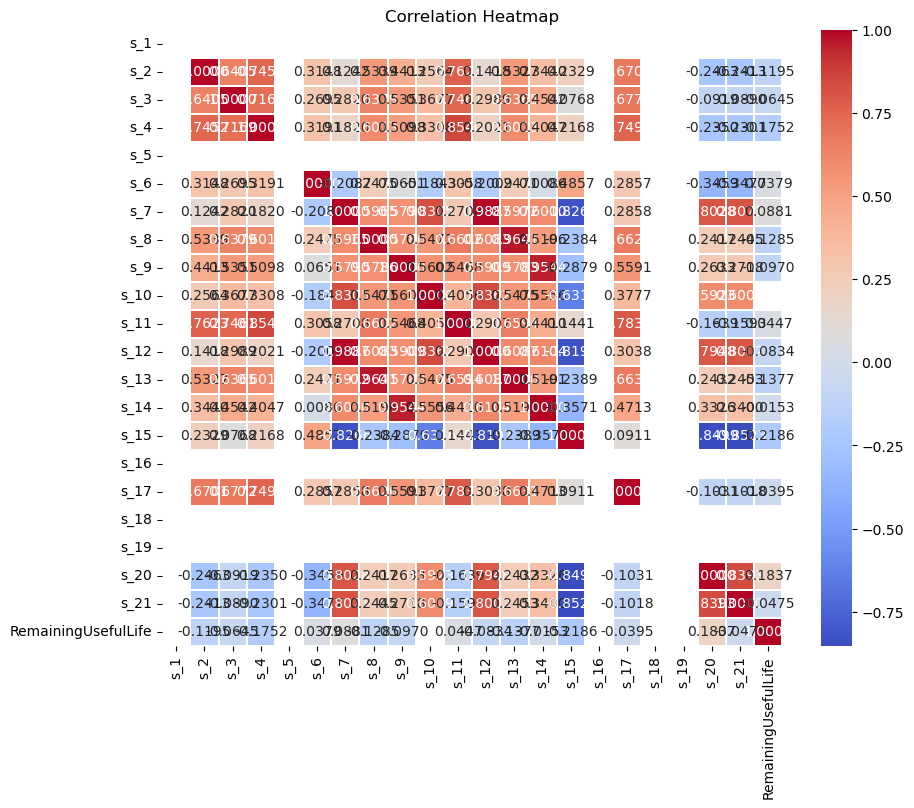

In [24]:
corr_matrix = corr_test.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=.1)

# Add labels and title
plt.title('Correlation Heatmap')
plt.show()

### It seems we need to remove several with over 70% correlation.

In [25]:
y_test

,RemainingUsefulLife
0,44
1,51
2,27
3,120
4,101
...,...
95,113
96,123
97,17
98,8


In [28]:
#X = X.drop(columns = [ 's_9','s_10', 's_11', 's_14', 's_15','s_20', 's_21'])

X_with_const = sm.add_constant(X)


model = sm.OLS(y_train, X_with_const)
results = model.fit()

results.summary()
                      
                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     3229.
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:31:22   Log-Likelihood:            -1.3830e+05
No. Observations:               24720   AIC:                         2.766e+05
Df Residuals:                   24709   BIC:                         2.767e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
s_1        -1.607e+10   1.76e+10     -0.911      0.362   -5.06e+10    1.85e+10
s_2          -19.9818      1.260    -15.865      0.000     -22.451     -17.513
s_3           -1.7118      0.097    -17.691      0.000      -1.902      -1.522
s_4           -2.0525      0.079    -26.139      0.000      -2.206      -1.899
s_5        -2.709e+08   2.97e+08     -0.911      0.362   -8.53e+08    3.12e+08
s_6          224.9127     26.863      8.373      0.000     172.260     277.566
s_7            0.6937      0.813      0.853      0.393      -0.900       2.287
s_8          -94.1926     10.066     -9.357      0.000    -113.923     -74.463
s_12          -0.2078      0.864     -0.241      0.810      -1.900       1.485
s_13        -115.5569     10.076    -11.469      0.000    -135.306     -95.808
s_16       -6.653e+05    7.3e+05     -0.911      0.362    -2.1e+06    7.65e+05
s_17          -7.8766      0.402    -19.594      0.000      -8.665      -7.089
s_18         3.63e+09   3.98e+09      0.911      0.362   -4.18e+09    1.14e+10
s_19       -3.308e+09   3.63e+09     -0.911      0.362   -1.04e+10    3.81e+09
==============================================================================
Omnibus:                     3962.021   Durbin-Watson:                   0.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7812.516
Skew:                           0.987   Prob(JB):                         0.00
Kurtosis:                       4.921   Cond. No.                     1.26e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.56e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### There has been no notable improvement of R^2 using OLS modeling. We will keep the reduced dataset and move to other model types

In [29]:
from sklearn.preprocessing import StandardScaler

# create scaler object
scaler = StandardScaler()

# fit scaler to our dataset (find mean, std
scaler.fit(X)

# apply z-score transformation
X1 = scaler.transform(X)

X1 = pd.DataFrame(X1, columns=X.columns)

In [31]:
X1_with_const = sm.add_constant(X1)

model = sm.OLS(y_train, X1_with_const)
results = model.fit()

results.summary()

E:\Users\mdubo\Anaconda\Lib\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     3706.
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:32:03   Log-Likelihood:            -1.3888e+05
No. Observations:               24720   AIC:                         2.778e+05
Df Residuals:                   24711   BIC:                         2.779e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
s_1                 0          0        nan        nan           0           0
s_2          -16.2713      0.675    -24.113      0.000     -17.594     -14.949
s_3           -8.8364      0.675    -13.094      0.000     -10.159      -7.514
s_4          -11.2870      0.786    -14.355      0.000     -12.828      -9.746
s_5        -3.984e+16   1.22e+14   -325.693      0.000   -4.01e+16   -3.96e+16
s_6            4.3805      0.498      8.791      0.000       3.404       5.357
s_7          -20.4283      2.862     -7.137      0.000     -26.038     -14.818
s_8          -16.8200      1.631    -10.310      0.000     -20.018     -13.622
s_12           7.8689      2.878      2.734      0.006       2.227      13.511
s_13         -11.0253      1.631     -6.758      0.000     -14.223      -7.828
s_16       -1.995e+14   6.12e+11   -325.693      0.000   -2.01e+14   -1.98e+14
s_17         -15.4717      0.725    -21.338      0.000     -16.893     -14.051
s_18                0          0        nan        nan           0           0
s_19                0          0        nan        nan           0           0
==============================================================================
Omnibus:                     4167.257   Durbin-Watson:                   0.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7824.940
Skew:                           1.055   Prob(JB):                         0.00
Kurtosis:                       4.773   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### R^2 also showing no significant improvement. 

In [32]:
X_train = X_train.drop (columns = [ 's_9','s_10', 's_11', 's_14', 's_15','s_20', 's_21'])

X_train

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_12,s_13,s_16,s_17,s_18,s_19
0,518.670,642.360,1583.230,1396.840,14.620,21.610,553.970,2387.960,522.310,2388.010,0.030,391,2388,100.000
1,518.670,642.500,1584.690,1396.890,14.620,21.610,554.550,2388.000,522.420,2388.030,0.030,392,2388,100.000
2,518.670,642.180,1582.350,1405.610,14.620,21.610,554.430,2388.030,522.030,2388.000,0.030,391,2388,100.000
3,518.670,642.920,1585.610,1392.270,14.620,21.610,555.210,2388.000,522.490,2388.080,0.030,392,2388,100.000
4,518.670,641.680,1588.630,1397.650,14.620,21.610,554.740,2388.040,522.580,2388.030,0.030,392,2388,100.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,518.670,643.780,1596.010,1424.110,14.620,21.610,551.860,2388.250,519.660,2388.300,0.030,394,2388,100.000
24716,518.670,643.290,1596.380,1429.140,14.620,21.610,551.860,2388.230,519.910,2388.280,0.030,395,2388,100.000
24717,518.670,643.840,1604.530,1431.410,14.620,21.610,551.300,2388.250,519.440,2388.240,0.030,396,2388,100.000
24718,518.670,643.940,1597.560,1426.570,14.620,21.610,550.690,2388.260,520.010,2388.260,0.030,395,2388,100.000


In [33]:
X_test = X_test.drop (columns = [ 's_9','s_10', 's_11', 's_14', 's_15','s_20', 's_21'])
X_test

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_12,s_13,s_16,s_17,s_18,s_19
0,518.670,642.590,1592.400,1409.870,14.620,21.580,560.530,2388.220,528.050,2388.230,0.030,393,2388,100.000
1,518.670,642.560,1587.420,1409.690,14.620,21.610,553.330,2388.180,520.900,2388.170,0.030,392,2388,100.000
2,518.670,642.750,1591.930,1417.660,14.620,21.600,563.610,2388.310,531.360,2388.330,0.030,395,2388,100.000
3,518.670,642.280,1584.680,1406.560,14.620,21.610,552.750,2388.070,521.270,2388.090,0.030,392,2388,100.000
4,518.670,642.150,1580.590,1397.260,14.620,21.580,553.820,2387.960,521.740,2387.960,0.030,390,2388,100.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,518.670,642.890,1592.930,1409.280,14.620,21.600,560.470,2388.210,527.720,2388.160,0.030,392,2388,100.000
96,518.670,642.320,1585.110,1390.010,14.620,21.610,554.600,2388.040,522.730,2387.980,0.030,392,2388,100.000
97,518.670,643.350,1592.180,1426.930,14.620,21.610,552.340,2388.200,520.870,2388.100,0.030,396,2388,100.000
98,518.670,642.780,1597.570,1419.470,14.620,21.590,566.570,2388.450,534.030,2388.470,0.030,397,2388,100.000


In [34]:
y_train_clipped

0        125
1        125
2        125
3        125
4        125
        ... 
24715      4
24716      3
24717      2
24718      1
24719      0
Name: RUL, Length: 24720, dtype: int64

# Train/test Split

Since the Data provided the Train/Test Split, we have split according to the provided datasets

In [35]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()
model1.fit(X_train, y_train_clipped)

y_train_pred_lin = model1.predict(X_train)
y_test_pred_lin  = model1.predict(X_test)

In [36]:
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

# r^2
r2_train = r2_score(y_train_clipped, y_train_pred_lin)
print(f'r^2 (train):  {r2_train}')

r2_test = r2_score(y_test, y_test_pred_lin)
print(f'r^2 (test):   {r2_test}')
print()

# MSE
mse_train = mean_squared_error(y_train, y_train_pred_lin)
print(f'MSE (train):  {mse_train}')

mse_test = mean_squared_error(y_test, y_test_pred_lin)
print(f'MSE (test):   {mse_test}')
print()

# RMSE
rmse_train = sqrt(mse_train)
print(f'RMSE (train): {rmse_train}')

rmse_test = sqrt(mse_test)
print(f'RMSE (test):  {rmse_test}')
print()

r^2 (train):  0.72238520180629
r^2 (test):   0.6673883742653854

MSE (train):  8039.907899794654
MSE (test):   569.9624835909337

RMSE (train): 89.66553351090181
RMSE (test):  23.87388706496983



## Linear Regression with the reduced features actually has a lower r^2 on the test set. 

# KNeighbors Regressor

In [37]:
from sklearn.neighbors import KNeighborsRegressor

nNeigh = 5

#model2 = KNeighborsRegressor(n_neighbors=nNeigh)
model2 = KNeighborsRegressor(n_neighbors=nNeigh,weights='uniform')
#model2 = KNeighborsRegressor(n_neighbors=nNeigh,weights='distance')

model2.fit(X_train, y_train_clipped)

y_train_pred_knn = model2.predict(X_train)
y_test_pred_knn  = model2.predict(X_test)

In [38]:
# r^2
r2_train = r2_score(y_train_clipped, y_train_pred_knn)
print(f'r^2 (train):  {r2_train}')

r2_test = r2_score(y_test, y_test_pred_knn)
print(f'r^2 (test):   {r2_test}')
print()

# MSE
mse_train = mean_squared_error(y_train, y_train_pred_knn)
print(f'MSE (train):  {mse_train}')

mse_test = mean_squared_error(y_test, y_test_pred_knn)
print(f'MSE (test):   {mse_test}')
print()

# RMSE
rmse_train = sqrt(mse_train)
print(f'RMSE (train): {rmse_train}')

rmse_test = sqrt(mse_test)
print(f'RMSE (test):  {rmse_test}')
print()

r^2 (train):  0.827238487596977
r^2 (test):   0.6227286966321616

MSE (train):  7994.245286407767
MSE (test):   646.4911999999999

RMSE (train): 89.41054348569729
RMSE (test):  25.42619122086515



# Decision Tree Regressor

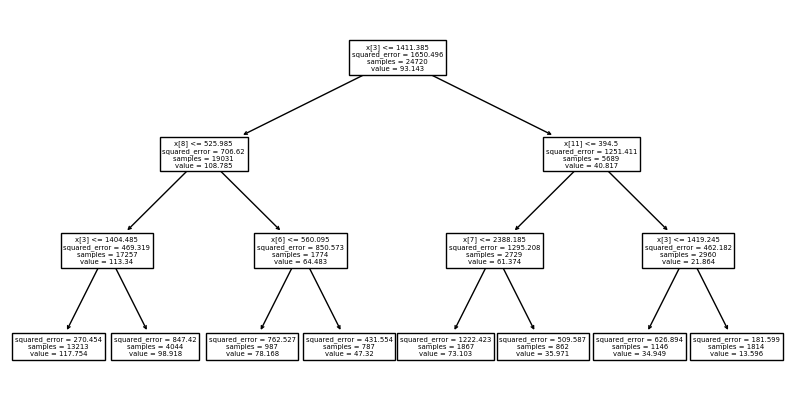

In [39]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

model3 = DecisionTreeRegressor(max_depth=3)
#model3 = DecisionTreeRegressor(min_samples_split=3)
#model3 = DecisionTreeRegressor()
model3.fit(X_train, y_train_clipped)

y_train_pred_tree = model3.predict(X_train)
y_test_pred_tree  = model3.predict(X_test)

plt.figure(figsize=(10,5))
#plot_tree(model3, rounded=True, fontsize=10);
plot_tree(model3);

In [40]:
# r^2
r2_train = r2_score(y_train_clipped, y_train_pred_tree)
print(f'r^2 (train):  {r2_train}')

r2_test = r2_score(y_test, y_test_pred_tree)
print(f'r^2 (test):   {r2_test}')
print()

# MSE
mse_train = mean_squared_error(y_train, y_train_pred_tree)
print(f'MSE (train):  {mse_train}')

mse_test = mean_squared_error(y_test, y_test_pred_tree)
print(f'MSE (test):   {mse_test}')
print()

# RMSE
rmse_train = sqrt(mse_train)
print(f'RMSE (train): {rmse_train}')

rmse_test = sqrt(mse_test)
print(f'RMSE (test):  {rmse_test}')
print()

r^2 (train):  0.7092642785090235
r^2 (test):   0.5494989221571437

MSE (train):  8614.216192163103
MSE (test):   771.9775657889318

RMSE (train): 92.81280187648201
RMSE (test):  27.784484263504545



# Random Forest Regressor

In [41]:
from sklearn.ensemble import RandomForestRegressor

model4 = RandomForestRegressor()
#model4 = RandomForestRegressor(n_estimators=100, max_depth=3)
#model4 = RandomForestRegressor(n_estimators=100, min_samples_split=3)
model4.fit(X_train, y_train_clipped)

y_train_pred_forest = model4.predict(X_train)
y_test_pred_forest = model4.predict(X_test)


In [42]:
# r^2
r2_train = r2_score(y_train_clipped, y_train_pred_forest)
print(f'r^2 (train):  {r2_train}')

r2_test = r2_score(y_test, y_test_pred_forest)
print(f'r^2 (test):   {r2_test}')
print()

# MSE
mse_train = mean_squared_error(y_train_clipped, y_train_pred_forest)
print(f'MSE (train):  {mse_train}')

mse_test = mean_squared_error(y_test, y_test_pred_forest)
print(f'MSE (test):   {mse_test}')
print()

# RMSE
rmse_train = sqrt(mse_train)
print(f'RMSE (train): {rmse_train}')

rmse_test = sqrt(mse_test)
print(f'RMSE (test):  {rmse_test}')
print()

r^2 (train):  0.9716784019741682
r^2 (test):   0.6981122650965431

MSE (train):  46.7446979328479
MSE (test):   517.3140980000001

RMSE (train): 6.837009429044829
RMSE (test):  22.744539960175057



### Usually RF is a powerhouse, but while the train set seemed overfitted with a very high r^2, the r^2 for test was only 69.8%

In [43]:
y_train_clipped.head(50).T

0     125
1     125
2     125
3     125
4     125
5     125
6     125
7     125
8     125
9     125
10    125
11    125
12    125
13    125
14    125
15    125
16    125
17    125
18    125
19    125
20    125
21    125
22    125
23    125
24    125
25    125
26    125
27    125
28    125
29    125
30    125
31    125
32    125
33    125
34    125
35    125
36    125
37    125
38    125
39    125
40    125
41    125
42    125
43    125
44    125
45    125
46    125
47    125
48    125
49    125
Name: RUL, dtype: int64

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score

models = [LinearRegression(), 
          KNeighborsRegressor( n_neighbors=2, weights='uniform' ),
          KNeighborsRegressor( n_neighbors=6, weights='uniform' ),
          KNeighborsRegressor( n_neighbors=25, weights='uniform' ),
          DecisionTreeRegressor(max_depth=3 ),
          DecisionTreeRegressor(max_depth=10 ),
          RandomForestRegressor( n_estimators =100, max_depth =3),
          RandomForestRegressor( n_estimators =100, max_depth =10),
          RandomForestRegressor(n_estimators=100, min_samples_split=3),
          GradientBoostingRegressor( n_estimators =100, learning_rate = 0.1, max_depth=3),
          GradientBoostingRegressor( n_estimators =100, learning_rate = 0.1, max_depth=4),
          GradientBoostingRegressor( n_estimators =100, learning_rate = 0.1, max_depth=5)         
         ]
          
          

In [93]:
for m in models:
    m.fit(X_train, y_train_clipped)
    
    y_train_pred = m.predict(X_train)
    y_test_pred = m.predict(X_test)
    
    print(m)
    
    r2_train = r2_score( y_train_clipped, y_train_pred)
    print(f'r^2 (train): {r2_train}')
    
    r2_test = r2_score( y_test, y_test_pred)
    print(f'r^2 (test): {r2_test}')
    print()
#end

LinearRegression()
r^2 (train): 0.72238520180629
r^2 (test): 0.6673883742653854

KNeighborsRegressor(n_neighbors=2)
r^2 (train): 0.8915019393698732
r^2 (test): 0.5491604913545631

KNeighborsRegressor(n_neighbors=6)
r^2 (train): 0.8197085983673625
r^2 (test): 0.6405854300657026

KNeighborsRegressor(n_neighbors=25)
r^2 (train): 0.7883378984922437
r^2 (test): 0.6743970603133431

DecisionTreeRegressor(max_depth=3)
r^2 (train): 0.7092642785090235
r^2 (test): 0.5494989221571437

DecisionTreeRegressor(max_depth=10)
r^2 (train): 0.8420858826786772
r^2 (test): 0.6515251071855059

RandomForestRegressor(max_depth=3)
r^2 (train): 0.7294826434780936
r^2 (test): 0.5766402245332716

RandomForestRegressor(max_depth=10)
r^2 (train): 0.8571577627625492
r^2 (test): 0.708438828310203

RandomForestRegressor(min_samples_split=3)
r^2 (train): 0.9689905559954297
r^2 (test): 0.707278858757435

GradientBoostingRegressor()
r^2 (train): 0.8082105366913113
r^2 (test): 0.7045641398444634

GradientBoostingRegressor(

## All in all GradientBoosting Regression with a depth of 5 performed the best with 72.4% of the variability being explained by the model. 

In [94]:
# Ensure both arrays have the same length
assert len(y_test) == len(y_test_pred)

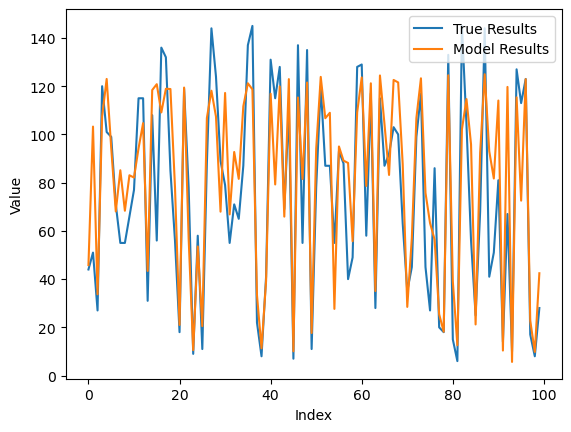

In [95]:
true_results = y_test
model_results = y_test_pred


# Plot the results
plt.plot(true_results, label='True Results')
plt.plot(model_results, label='Model Results')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

## What this means in the context of this problem. 

In many cases the GBR underpredicted the RUL of the test set. In this application, that is not a bad thing. We are predicting the failure of potentially passenger aircraft engines. We would rather the model underpredicte the true RUL, than to overpredict and the engines fail when we thought we had more time. 

Walking away with a model that only predicts 72% of the variability in the model is not ideal, but being able to be mainly underpredicting makes up for it. 